In [71]:
import numpy as np
import pandas as pd
import csv
import math

In [72]:
def calc_sec(time):
    hms = time.split(':')
    hms = [float(x) for x in hms]
    sec = hms[2] + hms[1]*60 + hms[0]*3600
    sec = round(sec,3)
    return sec

In [73]:
def calc_ts(sec):
    ts = ''
    hr = int(sec/3600)
    mn = int((sec - (hr*3600))/60)
    sc = sec - (hr*3600) - (mn*60)
    sc = round(sc,3)
    ts += str(hr) + ':' + str(mn) + ':' + str(sc)
    # print(ts)
    return ts

In [74]:
filepath = 'SmartwatchData/prep_data/data_activities.csv'
df = pd.read_csv(filepath)
# print(df.head())

df_grp = df.groupby('date')

idx = {}
df_key = {}

for key,item in df_grp:
    idx[key] = df_grp.get_group(key).index
    df_key[key] = df_grp.get_group(key)

dates = list(df_key.keys())

         date          time         x         y         z               label
0  2018-10-05  14:42:28.999  0.590171  0.414197  9.877279  walking_downstairs
1  2018-10-05  14:42:29.159  0.585382  0.519542  9.882068  walking_downstairs
2  2018-10-05  14:42:29.321  0.513556  0.524330  9.872491  walking_downstairs
3  2018-10-05   14:42:29.48  0.590171  0.538695  9.810242  walking_downstairs
4  2018-10-05  14:42:29.642  0.599748  0.720655  9.757569  walking_downstairs


In [75]:
key_list = ['time','x','y','z','label']
new_lines = []

# change from 160ms+-2ms to 1s
for d in dates:
    df_date = df.loc[df['date']==d]
    
    data_dict = {}
    
    for k in key_list:
        data_dict[k] = []
    
    for i in range(len(df_date)):
        for k in key_list:
            data_dict[k].append(df_date.iloc[i][k])
    
    prev_t = data_dict['time'][0]
    prev_sec = calc_sec(prev_t)
    
    exact_dur = 0.16

    trimmed_mean_list = []
    trimmed_mean_elem = []
    
    for i in range(len(data_dict['time'])):
        time = data_dict['time'][i]
        x = data_dict['x'][i]
        y = data_dict['y'][i]
        z = data_dict['z'][i]
        label = data_dict['label'][i]
        
        sec = calc_sec(time)

        duration = sec - prev_sec
        duration = round(duration,3)
        # print(duration)

        if(duration!=exact_dur and duration!=0.0 and duration<2*exact_dur):
            new_sec = prev_sec + exact_dur
        else:
            new_sec = prev_sec + duration

        diff_sec = math.floor(new_sec)-math.floor(prev_sec)
        
        if(diff_sec>=1):                           # If it's the first millisecond in timestamp
            trimmed_mean_np = np.array(trimmed_mean_list)
            # print(trimmed_mean_np)
            x_item = sorted([float(item[1]) for item in trimmed_mean_np])
            y_item = sorted([float(item[2]) for item in trimmed_mean_np])
            z_item = sorted([float(item[3]) for item in trimmed_mean_np])

            x_item = np.array(x_item[1:-1])         # Drop the min,max data in the list
            y_item = np.array(y_item[1:-1])
            z_item = np.array(z_item[1:-1])

            # print(math.floor(prev_sec))

            if(len(x_item)>0):
                x0 = round(np.mean(x_item),8)  # Calculate mean value on each axis
                y0 = round(np.mean(y_item),8)
                z0 = round(np.mean(z_item),8)
            else:
                x0 = trimmed_mean_np[0,1]
                y0 = trimmed_mean_np[0,2]
                z0 = trimmed_mean_np[0,3]

            prev_sec = math.floor(prev_sec)
            new_ts = calc_ts(prev_sec)
            # print(new_ts)
            
            elem = [d,new_ts,x0,y0,z0,label]
            
            new_lines.append(elem)

            trimmed_mean_list.clear()

            prev_sec = new_sec
            # print(prev_sec)

        trimmed_mean_elem = [new_sec,x,y,z,label]
        trimmed_mean_list.append(trimmed_mean_elem)

new_lines = np.array(new_lines)
# print(new_lines)


In [76]:
new_dict = {}
new_key_list = ['date','time','x','y','z','label']
for k in new_key_list:
    new_dict[k] = []
        
for line in new_lines:
    for i in range(len(new_key_list)):
        new_dict[new_key_list[i]].append(line[i])

new_df = pd.DataFrame(new_dict)
# print(new_df.head())

new_df = new_df.groupby('label',as_index=True)

ix = {}
dkey = {}
for key,item in new_df:
    ix[key] = new_df.get_group(key).index
    dkey[key] = new_df.get_group(key)
    
# print(dkey['walking'])

In [77]:
import matplotlib.pyplot as plt

['running', 'walking', 'walking_downstairs', 'walking_upstairs']


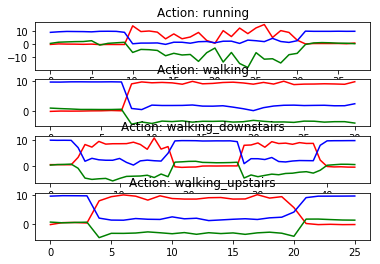

In [78]:
label_names = list(dkey.keys())
print(label_names)

ai_lb = {}

for i in range(len(label_names)):
    ai_lb[label_names[i]] = dkey[label_names[i]].values
# print(ai_lb)

for i in range(len(label_names)):
    lb = label_names[i]
    x_val = []
    y_val = []
    z_val = []
    for ts in ai_lb[lb]:
        x_val.append(float(ts[2]))
        y_val.append(float(ts[3]))
        z_val.append(float(ts[4]))
        
    plt.subplot(len(label_names),1,i+1)
    plt.plot(x_val,'r',label='X')
    plt.plot(y_val,'g',label='Y')
    plt.plot(z_val,'b',label='Z')    
    plt.title('Action: ' + label_names[i]) 
    
plt.show()